In [1]:
%load_ext autoreload
%autoreload 2
import json
from scipy import sparse
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import string
import scipy.stats as stats

# We must run scripts on Terrier with the parameters!

### So we run:

* Run the weights and queries in Terrier to get the reuslts file
    - bash rcv1-run-top5-idf-p-alpha.sh and variants (in terrier-core-4.2)
    - bin/trec_terrier.sh -r -Dtrec.model=models.BM25PAlpha  -Dbm25p.p=\$p -Dbm25p.alpha=\$alpha -Dbm25p.w
* Interpret the *.res file and see the position of the correct document for each query
    - bash eval-all.sh which calls
    - python eval-scoring-function-on-query-set-sample.py -i \$FILENAME -o ../results/TerrierOutput/eval/\$BASENAME.txt -t \$QT

# How we do it

#### Scoring functions to evaluate:
    - BM25 
    - BM25P10-top5-idf 
    - BM25P10-top5-tfidf 
    - BM25P10-top10-idf 
    - BM25P10-top10-tfidf

For each scoring function result file we evaluate the 4 query types (A,B,C and D). We have some intermediate files from which we read the position of the corrent doc match. We evaluate if in top 1,10,100.

What are the metrics we are interested in?
- Win/loss ratio
- Average rank
- Precision @ 1,10,100
- MRR

There might be some queries in the input files with no results

In [2]:
def loadJSON(sampleFilename):
    with open(sampleFilename) as json_data:
        sample_10000 = json.load(json_data)
    return sample_10000

## Metrics

In [3]:
def averageRank(rank_list):
    return np.mean(rank_list)

In [4]:
def winLossRatio(rank_list, interval = [0,1]):
    correct_class = [r for r in rank_list if r >= interval[0] and r < interval[1]]
#     print(len(correct_class),len(rank_list))
    if len(correct_class) == len(rank_list): return "-"
    else: return len(correct_class)/(len(rank_list) - len(correct_class))

In [5]:
def precision(rank, at=10):
    n_rel_retrieved = 0
    if rank <= at:
        n_rel_retrieved = 1
    return n_rel_retrieved/at

In [6]:
def avgPrecision(rank_list, at=1):
    prec_list = [precision(r, at) for r in rank_list]
    return np.mean(prec_list)

In [7]:
def MRR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return np.mean(inverse_ranks)

In [8]:
def RR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return inverse_ranks

In [9]:
### http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-24.html

In [10]:
def two_sample_ttest_ind(a,b):
    return stats.ttest_ind(a, b, equal_var=False)

In [11]:
def paired_ttest_rel(a, b):
    return stats.ttest_rel(a, b)

In [12]:
intervals = [[0,1], [1,10], [10,100], [100,1000]]

def getMetrics(ranks, positions, interval):
    print("Avg. rank:", averageRank(ranks))
    print("Win/loss", winLossRatio(positions, interval))
    print("Avg. P@1", avgPrecision(ranks, at=1))
    print("Avg. P@10", avgPrecision(ranks, at=10))
    print("Avg. P@100", avgPrecision(ranks, at=100))
    print("Avg. P@1000", avgPrecision(ranks, at=1000))
    print("MRR", MRR(ranks))

# EVAL 

In [13]:
queryTypes = ["A", "B", "C", "D"]

In [14]:
def getQueryTypeSets(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
    print("A",len(A))
    print("B", len(B))
    print("C",len(C))
    print("D", len(D))

In [15]:
def getQueryTypeSetsInline(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
#     return " , ".join([str(len(A)),str(len(B)),str(len(C)), str(len(D)), str(10000-len(A) -len(B)-len(C)-len(D))])
    return len(A), len(B), len(C), len(D)


### BM25

In [16]:
def evalBM25(filename, qt):
    
    Bm25queryRankDict = loadJSON(filename)

    positions = list(Bm25queryRankDict.values())
    ranks = [x+1 for x in positions]
    
    #pretty print, but no data
    getMetrics(ranks, positions, interval=intervals[queryTypes.index(qt)])
    getQueryTypeSets(positions)
    
    #get some data
    bm25_mrr = MRR(ranks)
    bm25_avg_ranks = np.mean(ranks)
    bm25_query_class = getQueryTypeSetsInline(positions)
#     print(bm25_mrr)
#     print(bm25_query_class)
    
    return bm25_mrr, bm25_avg_ranks, bm25_query_class

In [17]:
bm25_mrr_dict = dict()
bm25_avg_rank_dict = dict()
for qt in queryTypes:
    print(qt)
    filename = "../results/TerrierOutput/eval/BM25P-RCV1-bm25-plain-sample-1000-"+qt+"-p-10-alpha-0.txt"
    bm25_mrr, bm25_avg_ranks, bm25_query_class = evalBM25(filename, qt)
    bm25_mrr_dict[("bm25-plain", qt)] = bm25_mrr
    bm25_avg_rank_dict[("bm25-plain", qt)] = bm25_avg_ranks
    print()

A
Avg. rank: 1.0
Win/loss -
Avg. P@1 1.0
Avg. P@10 0.1
Avg. P@100 0.01
Avg. P@1000 0.001
MRR 1.0
A 1000
B 0
C 0
D 0

B
Avg. rank: 4.058
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.1
Avg. P@100 0.01
Avg. P@1000 0.001
MRR 0.319421031746
A 0
B 1000
C 0
D 0

C
Avg. rank: 37.951
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.01
Avg. P@1000 0.001
MRR 0.0386054399455
A 0
B 0
C 1000
D 0

D
Avg. rank: 338.686
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.0
Avg. P@1000 0.001
MRR 0.00435199615103
A 0
B 0
C 0
D 1000



In [18]:
bm25_mrr_dict 

{('bm25-plain', 'A'): 1.0,
 ('bm25-plain', 'B'): 0.31942103174603176,
 ('bm25-plain', 'C'): 0.038605439945459896,
 ('bm25-plain', 'D'): 0.0043519961510253861}

In [19]:
print(np.mean(list(bm25_avg_rank_dict.values())))
bm25_avg_rank_dict

95.42375


{('bm25-plain', 'A'): 1.0,
 ('bm25-plain', 'B'): 4.0579999999999998,
 ('bm25-plain', 'C'): 37.951000000000001,
 ('bm25-plain', 'D'): 338.68599999999998}

### BM25P 

In [20]:
# Settings
dirEval = "../results/TerrierOutput/eval/"
baseTypes = ["top5-idf", 
             "top5-tfidf",
             "top10-idf",
             "top10-tfidf"]
queryTypes = ["A", "B", "C", "D"]
ending = ".txt" # sometimes res

### MRR plots for different alpha

In [33]:
import os

mrr_dict = defaultdict(list)
rr_dict = defaultdict(list)
average_rank_dict = defaultdict(list)
for filename in os.listdir(dirEval):
    name_items = filename.split("-")
    baseType = name_items[2]+"-"+name_items[3]
    alpha = filename.split(".")[0].split("-")[10]
    
    if int(name_items[5])==1000: 
        queryRankDict = loadJSON(dirEval+filename)
        positions = list(queryRankDict.values())
        ranks = [x+1 for x in positions]
        mrr_dict[(baseType, name_items[6])].append(((int(alpha)), MRR(ranks)))
        rr_dict[(baseType, name_items[6])].append(((int(alpha)), RR(ranks)))
        average_rank_dict[(baseType, name_items[6])].append(((int(alpha)), np.mean(ranks)))

In [34]:
print(mrr_dict.keys())
mrr_dict[('top10-tfidf', 'D')]

dict_keys([('top10-tfidf', 'D'), ('top5-idf', 'A'), ('top10-idf', 'A'), ('top5-tfidf', 'D'), ('top5-tfidf', 'A'), ('top10-idf', 'B'), ('top5-idf', 'C'), ('top10-tfidf', 'A'), ('top5-idf', 'B'), ('top5-tfidf', 'C'), ('top10-idf', 'D'), ('bm25-plain', 'C'), ('top10-tfidf', 'C'), ('top10-idf', 'C'), ('top5-idf', 'D'), ('top5-tfidf', 'B'), ('top10-tfidf', 'B'), ('bm25-plain', 'A'), ('bm25-plain', 'D'), ('bm25-plain', 'B')])


[(50, 0.0095857833362925707),
 (10, 0.0055355147957074679),
 (30, 0.0081702256790066197),
 (35, 0.0083501543027882669),
 (15, 0.0063196644496978987),
 (25, 0.0077870586756524961),
 (20, 0.0069145630506473477),
 (5, 0.0050975297003893437),
 (40, 0.008604639077360891),
 (1, 0.0066330086347173205),
 (45, 0.0093790650064059771)]

In [39]:
def plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes):
    for queryType in queryTypes:
        key = (baseType, queryType)
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
#         print(x)
#         print(y)
        plt.plot(x,y , label=key)
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[y.index(max(y))], max(y), "or")
        # print bm25 as baseline
        baseline_y = [bm25_mrr_dict[("bm25-plain", queryType)]] * len(x)
#         print(baseline_y)
        plt.plot(x, baseline_y, label="('bm25-plain', " + str(queryType)+ "')", linestyle="--")
#         print()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("MRR@1000")
#     plt.axis([5,25,0,20]) # this is for zooming in
    plt.show()
    return plt

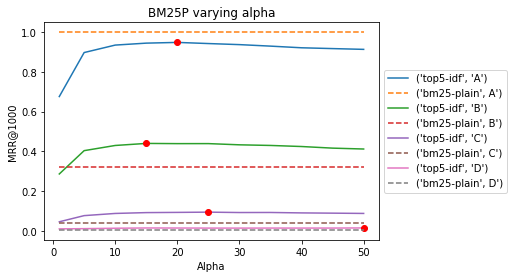

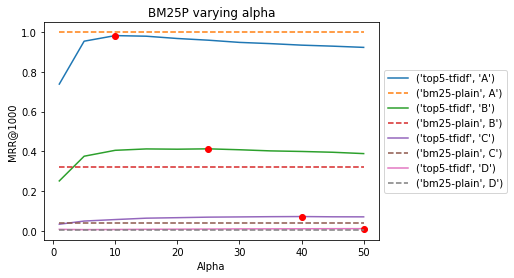

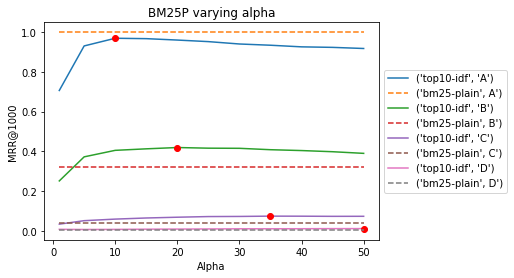

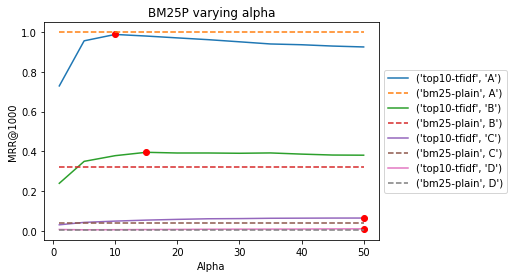

In [40]:
for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes)

# Average RANK 

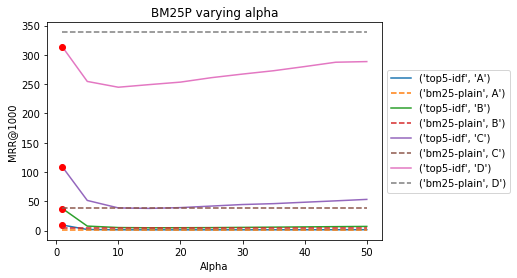

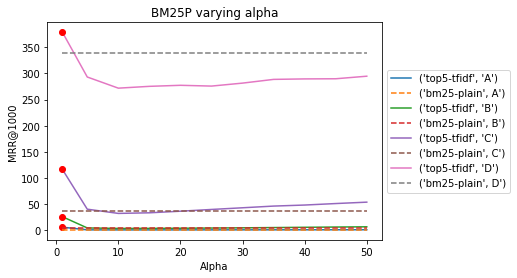

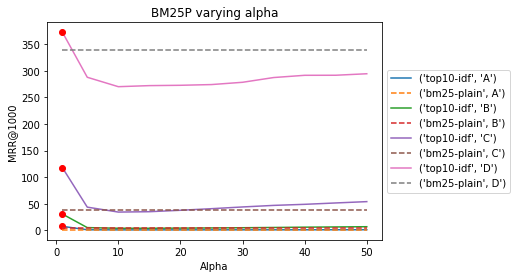

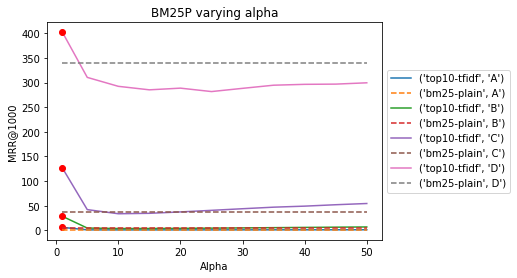

In [41]:
for baseType in baseTypes:
    a = plot_and_sort(baseType, average_rank_dict, bm25_avg_rank_dict, queryTypes)

In [42]:
for baseType in baseTypes:

    for queryType in queryTypes:
        key = (baseType, queryType)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]

        avg_rank_bm25 = bm25_avg_rank_dict[("bm25-plain", queryType)]
        #for i in range(len(y)):
        for i in [2,3,4,5,6]:
            
            print("\x1b[0m "+str(key), x[i], y[i], avg_rank_bm25, end='')
            print("\x1b[31m WIN" if y[i]<avg_rank_bm25 else "\x1b[0m ") 
        print()
        
    print("--------------------------------")

 ('top5-idf', 'A') 10 1.241 1.0 
 ('top5-idf', 'A') 15 1.167 1.0 
 ('top5-idf', 'A') 20 1.161 1.0 
 ('top5-idf', 'A') 25 1.184 1.0 
 ('top5-idf', 'A') 30 1.21 1.0 

 ('top5-idf', 'B') 10 5.032 4.058 
 ('top5-idf', 'B') 15 4.642 4.058 
 ('top5-idf', 'B') 20 4.747 4.058 
 ('top5-idf', 'B') 25 4.93 4.058 
 ('top5-idf', 'B') 30 5.326 4.058 

 ('top5-idf', 'C') 10 38.567 37.951 
 ('top5-idf', 'C') 15 37.784 37.951 WIN
 ('top5-idf', 'C') 20 39.085 37.951 
 ('top5-idf', 'C') 25 41.752 37.951 
 ('top5-idf', 'C') 30 44.379 37.951 

 ('top5-idf', 'D') 10 244.758218452 338.686 WIN
 ('top5-idf', 'D') 15 249.238145416 338.686 WIN
 ('top5-idf', 'D') 20 253.486228814 338.686 WIN
 ('top5-idf', 'D') 25 261.100742312 338.686 WIN
 ('top5-idf', 'D') 30 267.230277186 338.686 WIN

--------------------------------
 ('top5-tfidf', 'A') 10 1.045 1.0 
 ('top5-tfidf', 'A') 15 1.055 1.0 
 ('top5-tfidf', 'A') 20 1.093 1.0 
 ('top5-tfidf', 'A') 25 1.119 1.0 
 ('top5-tfidf', 'A') 30 1.164 1.0 

 ('top5-tfidf', 'B') 

In [43]:
print("BM25 avg rank :", np.mean(list(bm25_avg_rank_dict.values())))

for baseType in baseTypes:
    all_avg_rank = np.zeros(11)
    for queryType in queryTypes:
        key = (baseType, queryType)
#         print(key)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        all_avg_rank += np.array(y)
#         print(x)
#         print(y)
#         print(all_avg_rank)
    print()
    print(baseType+ " avg rank[1-50] : ", all_avg_rank/4)

BM25 avg rank : 95.42375

top5-idf avg rank[1-50] :  [ 117.26456115   78.82695916   72.39955461   73.20778635   74.6198072
   77.24168558   79.5363193    81.44876997   83.94927078   86.51056387
   87.51154415]

top5-tfidf avg rank[1-50] :  [ 131.83948809   84.88653339   77.27151348   78.46275611   79.80146704
   80.36131723   82.69494974   85.41682979   86.28056951   87.19586846
   89.20902618]

top10-idf avg rank[1-50] :  [ 132.26546493   84.61526254   77.49622938   78.17769845   79.07435417
   80.25729979   82.24661876   85.33515848   87.04552531   87.83743243
   89.28898364]

top10-tfidf avg rank[1-50] :  [ 140.82756873   89.64036024   82.7414947    81.22423523   82.85452564
   82.035        84.61316516   87.1356194    88.22844438   89.18787664
   90.59509824]



# Statistical significance for MRR values

In [33]:
print(rr_dict.keys())

dict_keys([('top5-tfidf', 'A'), ('top5-idf', 'A'), ('top5-tfidf', 'C'), ('top10-idf', 'B'), ('top10-tfidf', 'A'), ('top5-tfidf', 'D'), ('top10-idf', 'C'), ('top10-tfidf', 'C'), ('top5-tfidf', 'B'), ('top5-idf', 'D'), ('bm25-plain', 'A'), ('top5-idf', 'B'), ('top10-tfidf', 'D'), ('top10-tfidf', 'B'), ('top10-idf', 'A'), ('top10-idf', 'D'), ('top5-idf', 'C'), ('bm25-plain', 'B'), ('bm25-plain', 'D'), ('bm25-plain', 'C')])


## two pample paired - IND

In [34]:
def check_statistical_significance(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_index = x[y.index(max(y))]
        
        for first, second in zip(sorted_rr_list, sorted_rr_list[1:]):
            print(first[0], second[0])
            print(y[x.index(first[0])], y[x.index(second[0])])
            print(two_sample_ttest_ind(first[1], second[1]))

In [35]:
def check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_alpha = x[y.index(max(y))]
        print(max_alpha)
        max_rrs = sorted_rr_list[x.index(max_alpha)][1]
        
        for first in sorted_rr_list:
            print(first[0], max_alpha)
            print(y[x.index(first[0])], y[x.index(max_alpha)])
            print(two_sample_ttest_ind(first[1], max_rrs))

In [ ]:
check_statistical_significance_with_max('top5-idf', rr_dict, mrr_dict, queryTypes)

In [ ]:
for baseType in baseTypes:
    check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes)

# T-test for 2 related sample scores
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

In [40]:
def check_statistical_significance_with_baseline(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
#         print(sorted_rr_list) # list of (alpha, rr_list)
#         print([x for x,y in sorted_rr_list])
        
        
        base_rr_list = rr_dict[("bm25-plain", queryType)]
        sorted_base_rr_list = sorted(base_rr_list, key=lambda tup: tup[0])
#         print(sorted_base_rr_list) # list of (alpha, rr_list) 
#         print([x for x,y in sorted_base_rr_list])
        

        
        for first in sorted_rr_list:
            print(first[0], sorted_base_rr_list[0][0])
            print(np.mean(first[1]), np.mean(sorted_base_rr_list[0][1]))
            print(two_sample_ttest_ind(first[1], sorted_base_rr_list[0][1]))

In [41]:
check_statistical_significance_with_baseline('top5-idf', rr_dict, mrr_dict, queryTypes)

#### ALL are statistically different!!!

('top5-idf', 'A')
1 0
0.696942995375 1.0
Ttest_indResult(statistic=-78.794087441854501, pvalue=0.0)
5 0
0.892893203286 1.0
Ttest_indResult(statistic=-43.024773291798603, pvalue=0.0)
10 0
0.930351564523 1.0
Ttest_indResult(statistic=-35.342507747195825, pvalue=6.205617719850299e-258)
15 0
0.940524444887 1.0
Ttest_indResult(statistic=-32.909038398298719, pvalue=1.3183975392404797e-225)
20 0
0.94010042822 1.0
Ttest_indResult(statistic=-32.903971848714995, pvalue=1.5326329942162498e-225)
25 0
0.935574541818 1.0
Ttest_indResult(statistic=-34.218933166314415, pvalue=8.8089482098888726e-243)
30 0
0.930732112556 1.0
Ttest_indResult(statistic=-35.370452431093184, pvalue=2.5767392096794959e-258)
35 0
0.926396553614 1.0
Ttest_indResult(statistic=-36.32725724327365, pvalue=1.5890281291112876e-271)
40 0
0.92052621518 1.0
Ttest_indResult(statistic=-37.732317677103104, pvalue=2.0721818440959863e-291)
45 0
0.915806418379 1.0
Ttest_indResult(statistic=-38.737408199682058, pvalue=5.5705752049105437e-306

### WIN/LOSS ratio for varying alpha

In [53]:
import os

class_dict = defaultdict(list)
for filename in os.listdir(dirEval):
    name_items = filename.split("-")
    baseType = name_items[2]+"-"+name_items[3]
    alpha = filename.split(".")[0].split("-")[10]
    
    queryRankDict = loadJSON(dirEval+filename)
    positions = list(queryRankDict.values())
    ranks = [x+1 for x in positions]
    new_class = getQueryTypeSetsInline(positions)
    class_dict[(baseType, name_items[6])].append(((int(alpha)), new_class))

In [54]:
def getWinLossRatio(baseType, queryType, alpha, class_dict):
    line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
    if queryType == "A":
        losses = sum(line[1][1:])
        wins = []
        for queryType in ["B","C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][0])
        return sum(wins)/losses
    if queryType == "B":
        losses = sum(line[1][2:])
        wins = []
        for queryType in ["C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][1])
        return sum(wins)/losses
    if queryType == "C":
        losses = sum(line[1][3:])
        wins = []
        for queryType in ["D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][2])
        return sum(wins)/losses
        

In [55]:
getWinLossRatio("top5-tfidf", "C", 10, class_dict)

5.669456066945607

In [56]:
win_loss_dict = defaultdict(list) ### the list contains WL for multiple alpha

for baseType in baseTypes:
    for queryType in queryTypes:
        if queryType is not "D":
            for alpha,_ in class_dict[(baseType, queryType)]:
                wl = getWinLossRatio(baseType, queryType, alpha, class_dict)
                win_loss_dict[(baseType, queryType)].append(((int(alpha)), wl))

In [57]:
print(win_loss_dict)

defaultdict(<class 'list'>, {('top5-idf', 'A'): [(20, 2.015655577299413), (40, 1.5544554455445545), (1, 0.27850283181482394), (50, 1.4104166666666667), (30, 1.7611301369863013), (35, 1.684596577017115), (45, 1.4742193173565723), (25, 1.8652094717668488), (10, 1.6786632390745502), (15, 1.9657869012707723), (5, 1.0797101449275361)], ('top5-idf', 'B'): [(50, 1.62015503875969), (30, 2.32776617954071), (20, 2.880050505050505), (45, 1.756198347107438), (25, 2.6039260969976907), (15, 3.1966987620357634), (10, 2.844932844932845), (40, 1.8915343915343916), (1, 0.3241398143091207), (5, 1.5195086705202312), (35, 2.0636882129277567)], ('top5-idf', 'C'): [(5, 1.9134532990574122), (45, 1.4040178571428572), (30, 1.9396551724137931), (50, 1.3111268603827073), (1, 0.4286694101508916), (10, 2.9610894941634243), (20, 2.6649810366624527), (40, 1.5161799526440412), (35, 1.697934595524957), (25, 2.211087420042644), (15, 3.095435684647303)], ('top5-tfidf', 'A'): [(1, 0.221395881006865), (5, 1.212871287128712

In [58]:
def plot_and_sort_WL(baseType, win_loss_dict, queryTypes):
    for queryType in ["A","B","C"]:
        key = (baseType, queryType)
        wl_list = win_loss_dict[key]
#         print(key)
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(x)
        y = [y for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(y)
        plt.plot(x, y , label=key)
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[y.index(max(y))], max(y), "or")
    plt.plot(x, [1 for x in range(len(x))], ":k", label="win-loss threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("WinLossRatio")
    plt.show()

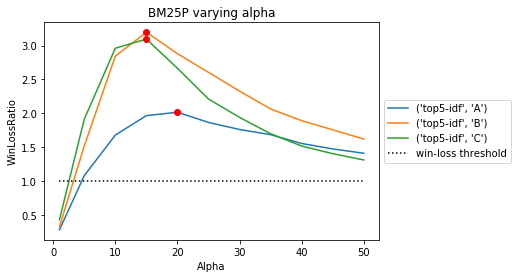

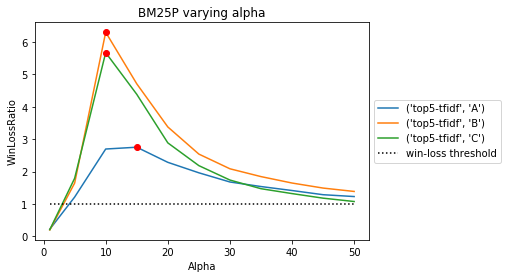

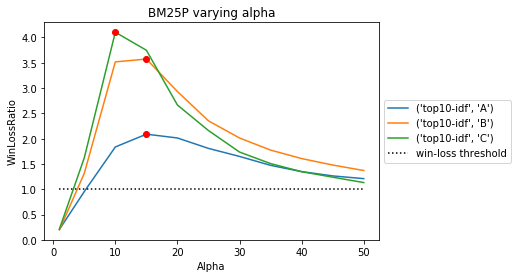

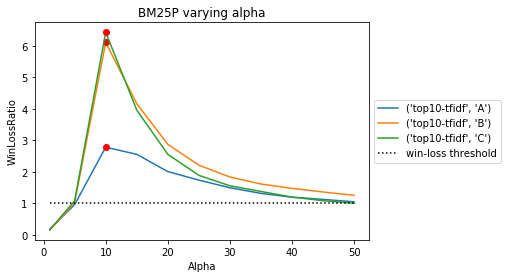

In [59]:
for baseType in baseTypes:
    plot_and_sort_WL(baseType, win_loss_dict, queryTypes)

## Todo:

- intersect qid from wins of C for alpha 10 with wins of C for alpha 40